In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append('../functions/')

from adjust_lon_xr_dataset import adjust_lon_xr_dataset
from convert_era5_to_Wm2 import convert_era5_to_Wm2

from map_plotting import southern_ocean_map
import cartopy
import cartopy.crs as ccrs


from scipy.interpolate import griddata
import gsw

In [2]:
def convert_longitude(longitude):
    if longitude < 0:
        return longitude + 360
    else:
        return longitude

#### Read and save original cyclone tracks

This only needs to happen once as it is saved as a final product that is easier to read in

In [8]:
ds_cyclones = xr.open_dataset('/home/mduplessis/data/storms/ec_centers_1981_2020.nc')

In [9]:
# read in the cyclone dataset

ds_summer = ds_cyclones.sel(TIME=ds_cyclones.TIME.dt.season=="DJF")
ds_summer = ds_summer.isel(TIME=ds_summer.LATITUDE.data < -40)

In [11]:
# read in the land sea mask from era5

lsm = xr.open_dataset('/home/mduplessis/data/era5/land_sea_mask.nc')

lsm = adjust_lon_xr_dataset(lsm).sel(latitude=slice(-40, -90))

lsm_lats = lsm.latitude.values
lsm_lons = lsm.longitude.values

In [12]:
# create lon/lat array where there is land (>0)

land_lons = []
land_lats = []

for i, lon in tqdm(enumerate(lsm_lons)):

    for j, lat in enumerate(lsm_lats):

        if lsm.sel(longitude=lon, latitude=lat).lsm > 0:

            land_lons += lon,
            land_lats += lat, 

land_lons = np.array(land_lons)
land_lats = np.array(land_lats)

1440it [01:31, 15.74it/s]


In [13]:
# remove bad lon and lats around islands - we don't want to lose too many cyclones

# south of aus & nz
idx = ((land_lons > 135) & (land_lons < 180) & (land_lats > -60) & (land_lats < -48))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

# atlantic, indian
idx = ((land_lons > -62) & (land_lons < 135) & (land_lats > -63))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

# west of nz
idx = ((land_lons > -180) & (land_lons < -160) & (land_lats > -70))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

# ross sea
idx = ((land_lons > 155) & (land_lats > -68) & (land_lats < -50))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

# abs
idx = ((land_lons > -135) & (land_lons < -76) & (land_lats > -70))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

In [14]:
# Precompute radians for land coordinates
land_lats_rad = np.radians(land_lats)
land_lons_rad = np.radians(land_lons)

# Precompute radians for cyclone coordinates
cyc_lats = ds_summer.LATITUDE.values
cyc_lons = ds_summer.LONGITUDE.values

cyc_lats_rad = np.radians(cyc_lats)
cyc_lons_rad = np.radians(cyc_lons)

In [15]:
def earth_radius(lat_radians):
    # Equatorial and polar radii in kilometers, insert latitude in radians
    a = 6378.137
    b = 6356.752
    R = np.sqrt(((a**2 * np.cos(lat_radians))**2 + (b**2 * np.sin(lat_radians))**2) / ((a * np.cos(lat_radians))**2 + (b * np.sin(lat_radians))**2))
    return R

def haversine_rad(lat1, lon1, lat2, lon2):
    R1 = earth_radius(lat1)  # insert latitude in radians
    R2 = earth_radius(lat2)  # insert latitude in radians
    R = (R1 + R2) / 2  # Average radius for the two latitudes
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [ ]:
# Initialize the result array
min_dist_to_land = np.ndarray([ds_summer.TIME.size])

# Vectorized distance calculation
for i in tqdm(range(ds_summer.TIME.size)):

    cyc_lat = cyc_lats_rad[i]
    cyc_lon = cyc_lons_rad[i]    
    
    # Calculate distances to all land points at once
    distances = haversine_rad(land_lats_rad, land_lons_rad, cyc_lat, cyc_lon)
    min_dist_to_land[i] = distances.min()

  2%|▏         | 13482/849212 [00:51<53:19, 261.20it/s]

In [ ]:
ds_summer['min_dist_to_land'] = (('TIME'), min_dist_to_land)

In [ ]:
ds_summer.to_netcdf('/home/mduplessis/data/storms/ec_centers_1981_2020_with_min_dist_to_land.nc')

#### Read and process cyclone tracks

In [5]:
# read in storm center data with min dist to land

ds_summer = xr.open_dataset('/Volumes/LaCie/Work/data/lodise2022_cyclones/ec_centers_1981_2020_with_min_dist_to_land.nc')

In [6]:
# pick out all the cyclones that are within 500 km of land

ds_summer_ocean = ds_summer.isel(TIME=ds_summer.min_dist_to_land>500)

In [7]:
# remove cyclone before december 1981

ds_summer_ocean = ds_summer_ocean.isel(TIME=ds_summer_ocean.TIME > np.datetime64('1981-12-01T00:00:00'))

In [8]:
# storm number count before land removal of storms
print('all storms:', np.unique(ds_summer.STORM_ID).size)

# storm number count where ocean only storms
print('ocean storms:', np.unique(ds_summer_ocean.STORM_ID).size)

all storms: 14895
ocean storms: 13774


NameError: name 'land_lons' is not defined

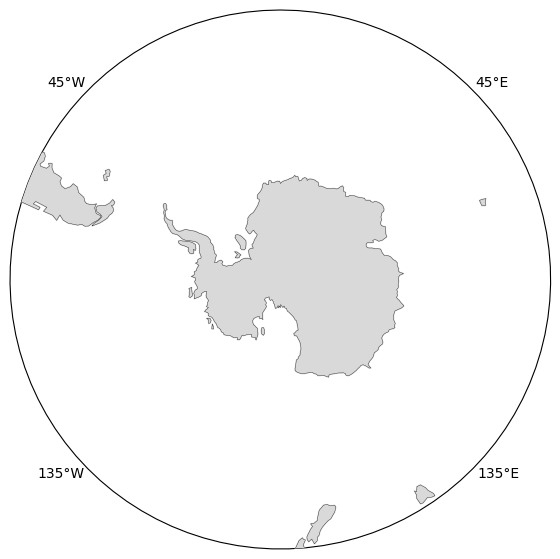

In [9]:
# plot storm tracks

fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(projection=ccrs.SouthPolarStereo())

ax = southern_ocean_map(ax)

ax.scatter(land_lons, land_lats, s=0.1, c='tab:blue', transform=ccrs.PlateCarree())

ax.scatter(ds_summer_ocean.LONGITUDE, ds_summer_ocean.LATITUDE, s=1, alpha=0.2, lw=0, c='tab:purple', transform=ccrs.PlateCarree())

In [10]:
len_storms = [ds_summer_ocean.isel(TIME=ds_summer_ocean.STORM_ID==storm).TIME.size for storm in np.unique(ds_summer_ocean.STORM_ID)]

(array([4.930e+02, 6.980e+02, 7.970e+02, 7.760e+02, 1.782e+03, 1.576e+03,
        1.352e+03, 1.149e+03, 9.600e+02, 8.170e+02, 7.020e+02, 5.080e+02,
        4.200e+02, 3.560e+02, 2.870e+02, 2.260e+02, 1.890e+02, 1.540e+02,
        1.240e+02, 9.100e+01, 6.800e+01, 6.700e+01, 4.800e+01, 2.500e+01,
        2.600e+01, 2.100e+01, 1.100e+01, 7.000e+00, 1.300e+01, 9.000e+00,
        7.000e+00, 4.000e+00, 5.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00]),
 array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.,
         66.,  72.,  78.,  84.,  90.,  96., 102., 108., 114., 120., 126.,
        132., 138., 144., 150., 156., 162., 168., 174., 180., 186., 192.,
        198., 204., 210., 216., 222., 228., 234., 240., 246., 252., 258.]),
 <BarContainer object of 43 artists>)

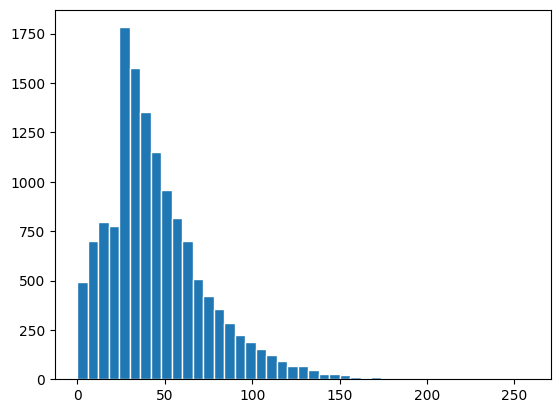

In [11]:
plt.hist(np.array(len_storms), bins=np.arange(0, 264, 6), edgecolor='w')

In [12]:
# filter out storms that are less than 24 hours long

storm_id_24hours = np.unique(ds_summer_ocean.STORM_ID)[np.array(len_storms)<24]

filter_array = []

for unique_storm_id in tqdm(np.unique(ds_summer_ocean.STORM_ID)):
    
    if unique_storm_id in storm_id_24hours:
        filter_array.append(np.zeros(ds_summer_ocean.isel(TIME=ds_summer_ocean.STORM_ID==unique_storm_id).TIME.size))

    else:
        filter_array.append(np.ones(ds_summer_ocean.isel(TIME=ds_summer_ocean.STORM_ID==unique_storm_id).TIME.size))

filter_array = np.concatenate(filter_array)

ds_summer_ocean_filtered = ds_summer_ocean.isel(TIME=filter_array==1)        

100%|██████████| 13774/13774 [00:21<00:00, 635.56it/s]


In [13]:
# create new storm id for the filtered dataset

new_storm_id = []
counter = 0

for unique_storm_id in tqdm(np.unique(ds_summer_ocean_filtered.STORM_ID)):
     
    counter += 1

    new_storm_id.append(np.zeros(ds_summer_ocean_filtered.isel(TIME=ds_summer_ocean_filtered.STORM_ID==unique_storm_id).TIME.size) + counter)

new_storm_id = np.concatenate(new_storm_id).astype(int)

ds_summer_ocean_filtered['STORM_ID'] = (('TIME'), new_storm_id)

100%|██████████| 11010/11010 [00:16<00:00, 668.07it/s]


In [14]:
len_storms = [ds_summer_ocean_filtered.isel(TIME=ds_summer_ocean_filtered.STORM_ID==storm).dims['TIME'] for storm in np.unique(ds_summer_ocean_filtered.STORM_ID)]

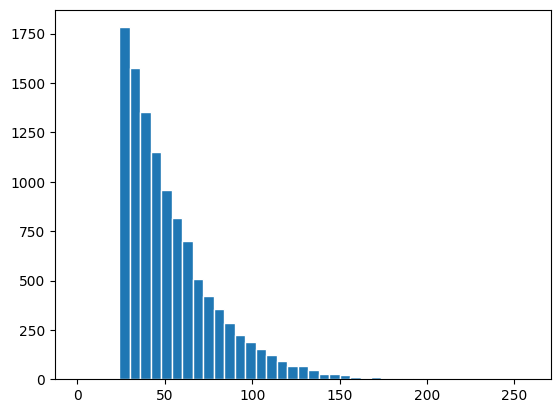

In [15]:
fig = plt.hist(np.array(len_storms), bins=np.arange(0, 264, 6), edgecolor='w')

In [36]:
ds_summer_ocean_filtered.to_netcdf('/Volumes/LaCie/Work/data/lodise2022_cyclones/ec_centers_1981_2020_500km_from_land_filtered_24hours.nc')

#### Load the functions that will be used to calculate the storm properties

In [ ]:
ds_summer_ocean_filtered = xr.open_dataset('/Volumes/LaCie/Work/data/lodise2022_cyclones/ec_centers_1981_2020_500km_from_land_filtered_24hours.nc')

In [16]:
def read_era5_dataset(name, year):
    print(f'reading in era5 dataset for {name} {year}')
    data_directory_in = f'/Volumes/LaCie/Work/data/era5/DJF_1981_2023_hourly_means/DJF_1981_2023_{name}/*.nc'
    file_list = sorted(glob(data_directory_in))
    
    year_str = str(year)
    next_year_str = str(year + 1)
    months = [f'{year_str}12.nc', f'{next_year_str}01.nc', f'{next_year_str}02.nc']
    
    # choose only the files that are dec, jan or feb
    filtered_files = [file for file in file_list if any(file.endswith(month) for month in months)]
    
    ds = xr.open_mfdataset(filtered_files)
    ds = ds.sel(latitude=slice(-30, -90)).load()

    ds_adjusted = adjust_lon_xr_dataset(ds)

    return ds, ds_adjusted

In [17]:
def select_data_by_year(ds, year):
    """
    Selects a portion of the data based on the given year.

    Parameters:
    ds (xarray.Dataset): The dataset to select data from.
    year (int): The year to select data for.

    Returns:
    xarray.Dataset: The dataset containing data for the specified year.
    """
    print(f'Selecting storm data for year {year}')
    return ds.isel(TIME=((ds.TIME > np.datetime64(f'{year}-12-01')) & (ds.TIME < np.datetime64(f'{year+1}-03-01'))))

# Example usage:
# year = 1981
# ds_storms_1981 = select_data_by_year(ds_summer_ocean, year)
# print(ds_storms_1981)

In [18]:
def process_storm_data(var, ds, ds_adjusted, storm_ds, storm_id):
    print(f'Processing data for storm {storm_id} of {np.unique(storm_ds.STORM_ID).size}')

    new_x = np.arange(-1000, 1050, 50)
    new_y = np.arange(-1000, 1050, 50)

    ds_storm = storm_ds.isel(TIME=storm_ds.STORM_ID == storm_id)

    which_lon_grid = np.ndarray([ds_storm.TIME.size])
    lons = np.ndarray([ds_storm.TIME.size, 241])
    lats = np.ndarray([ds_storm.TIME.size, 81])

    # ds_final = xr.Dataset()

    for time_idx in range(ds_storm.TIME.size):
        cyclone = ds_storm.isel(TIME=time_idx)  # choose one cyclone position at a time

        ref_lat = np.round(cyclone.LATITUDE.values)

        if (cyclone.LONGITUDE > 145) or (cyclone.LONGITUDE < -145):            
            ref_lon = np.round(convert_longitude(cyclone.LONGITUDE.values))

            ds_ = ds.sel(time=cyclone.TIME.values,
                         latitude=slice(np.round(ref_lat) + 10, np.round(ref_lat) - 10),
                         longitude=slice(np.round(ref_lon) - 30, np.round(ref_lon) + 30))
            
            which_lon_grid[time_idx] = 1  # give a value that represents a grid of 0 to 360

        else:
            ref_lon = np.round(cyclone.LONGITUDE.values)

            ds_ = ds_adjusted.sel(time=cyclone.TIME.values,
                                  latitude=slice(np.round(ref_lat) + 10, np.round(ref_lat) - 10),
                                  longitude=slice(np.round(ref_lon) - 30.0, np.round(ref_lon) + 30))
            
            which_lon_grid[time_idx] = 0  # give a value that represents a grid of -180 to 180

        lats = ds_.latitude.values
        lons = ds_.longitude.values

        # longitude to distance interpolation
        dist_from_lon = np.zeros([81, 241])

        for j, lt in enumerate(lats):
            for i, ln in enumerate(lons):
                dist_from_lon[j, i] = gsw.distance([ln, ref_lon], [lt, lt])[0] / 1000

            dist_from_lon[j][lons < ref_lon] = -dist_from_lon[j][lons < ref_lon]

        # latitude to distance interpolation
        dist_from_lat = np.zeros(lats.size)

        for j, lt in enumerate(lats):
            dist_from_lat[j] = gsw.distance([lons[0], lons[0]], [lt, ref_lat])[0] / 1000

        dist_from_lat[lats < ref_lat] = -dist_from_lat[lats < ref_lat]

        for v in var:
            new_data = np.zeros([81, new_x.size])
            final_data = np.zeros([new_x.size, new_y.size])

            data = ds_[v]

            for j in range(lats.size):
                new_data[j, :] = griddata(dist_from_lon[j], data[j], new_x)

            for i in range(new_x.size):
                final_data[:, i] = griddata(dist_from_lat, new_data[:, i], new_y)

            ds_var = xr.Dataset(
                {v: (['time', 'x', 'y'], final_data[np.newaxis, :, :]),
                 'pressure': (['time'], [cyclone.PRESSURE_MIN.data]),
                 'storm_id': (['time'], [cyclone.STORM_ID.data]),
                 },
                coords={
                    'x': ('x', new_x),
                    'y': ('y', new_y),
                    'time': ('time', [pd.to_datetime(cyclone.TIME.data)]),
                    'lon': ('time', [ref_lon]),
                    'lat': ('time', [ref_lat]),                
                }
            )
    
            if 'ds_final' in locals() and isinstance(ds_final, xr.Dataset):
                ds_final = xr.concat([ds_final, ds_var], dim='time')

            else:
                ds_final = ds_var 

    ## Example padding logic (adjust as needed)
    max_time_length = 300  # Define a maximum length for the time dimension
    time_length = ds_final.dims['time']
    #
    if time_length < max_time_length:
        pad_width = max_time_length - time_length
        pad_values = {dim: (0, pad_width) for dim in ds_final.dims if dim == 'time'}
        ds_final = ds_final.pad(pad_values, constant_values=0)           
    
    return ds_final

# Example usage:
#var = ['t2m']
#ds_final = process_storm_data(var, era5_ds, era5_ds_adjusted, ds_storms_1981, ds_storms_1981.STORM_ID[0])

In [20]:
from joblib import Parallel, delayed

def process_storms(names, vars, storms_ds, year, storm_id=None):
    """
    Function to process all storms for a given year or a specific storm.
    Args:
    name: str
        Name of the dataset to be used. Options: '2m_temperature', 'winds', 'sea_ice_cover'
    var: str
        Variable to be processed. Options: 't2m', 'u10', 'v10', 'siconc'
    storms_ds: xarray.Dataset
        Dataset containing the storms data
    year: int
        Year to be processed
    storm_id: int
        Storm ID to be processed. If None, all storms for the year will be processed

    Returns:
    ds_all: xarray.Dataset
        Dataset containing the processed data
    """
    import numpy as np
    import xarray as xr

    def read_and_merge_datasets(names, year):
        datasets = [read_era5_dataset(name, year) for name in names]
        era5_ds_all = xr.merge([ds[0] for ds in datasets])
        era5_ds_adjusted_all = xr.merge([ds[1] for ds in datasets])
        return era5_ds_all, era5_ds_adjusted_all

    era5_ds_all, era5_ds_adjusted_all = read_and_merge_datasets(names, year)
    ds_storms_year = select_data_by_year(storms_ds, year)

    def process_single_storm(storm):
        return process_storm_data(vars, era5_ds_all, era5_ds_adjusted_all, ds_storms_year, storm)

    if storm_id is None:
        print(f'No storms provided, using all storms for the year {year}. Total number of storms: {len(np.unique(ds_storms_year.STORM_ID.values))}')
        storm_ids = np.unique(ds_storms_year.STORM_ID.values)

        # Use parallel processing to handle multiple storms simultaneously
        results = Parallel(n_jobs=-1)(delayed(process_single_storm)(storm) for storm in storm_ids)
        ds_all = xr.concat(results, dim='time', join='outer')

    else:
        storm = storm_id
        ds_all = process_single_storm(storm)

    return ds_all

In [22]:
# ds_test = ds_summer_ocean_filtered.isel(TIME=ds_summer_ocean_filtered.STORM_ID==8)

# ds_test = ds_test.assign_coords(TIME = ds_test.TIME.astype(np.datetime64))

In [24]:
for year in tqdm(range(1981, 2022)):

    ds_summer_ocean_year = ds_summer_ocean_filtered.isel(TIME=ds_summer_ocean_filtered.TIME < np.datetime64(f'{year+1}-03-01T00:00:00'))

    ds_summer_ocean_year = ds_summer_ocean_year.isel(TIME=ds_summer_ocean_year.TIME > np.datetime64(f'{year}-12-01T00:00:00'))

    ds_all = process_storms(names=['net_solar_radiation'], vars=['ssr'], storms_ds=ds_summer_ocean_year, year=year, storm_id=None)

    ds_all = ds_all.isel(time=~np.isnat(ds_all.time))

    ds_all.to_netcdf(f'/Volumes/LaCie/Work/data/storms/storm_winds_{year}.nc')

    del(ds_all)

  0%|          | 0/41 [00:00<?, ?it/s]

reading in era5 dataset for net_solar_radiation 1981
Selecting storm data for year 1981
No storms provided, using all storms for the year 1981. Total number of storms: 265
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R)

  2%|▏         | 1/41 [32:51<21:54:08, 1971.22s/it]

reading in era5 dataset for net_solar_radiation 1982
Selecting storm data for year 1982
No storms provided, using all storms for the year 1982. Total number of storms: 268
Processing data for storm 267 of 268
Processing data for storm 268 of 268
Processing data for storm 266 of 268
Processing data for storm 270 of 268
Processing data for storm 269 of 268
Processing data for storm 271 of 268
Processing data for storm 272 of 268
Processing data for storm 273 of 268
Processing data for storm 274 of 268
Processing data for storm 275 of 268
Processing data for storm 276 of 268
Processing data for storm 277 of 268
Processing data for storm 278 of 268
Processing data for storm 279 of 268
Processing data for storm 280 of 268
Processing data for storm 281 of 268
Processing data for storm 282 of 268
Processing data for storm 283 of 268
Processing data for storm 284 of 268
Processing data for storm 285 of 268
Processing data for storm 286 of 268
Processing data for storm 287 of 268
Processing dat

  5%|▍         | 2/41 [1:04:44<20:59:14, 1937.29s/it]

reading in era5 dataset for net_solar_radiation 1983
Selecting storm data for year 1983
No storms provided, using all storms for the year 1983. Total number of storms: 274
Processing data for storm 534 of 274
Processing data for storm 535 of 274
Processing data for storm 536 of 274
Processing data for storm 537 of 274
Processing data for storm 538 of 274
Processing data for storm 539 of 274
Processing data for storm 540 of 274
Processing data for storm 541 of 274
Processing data for storm 542 of 274
Processing data for storm 543 of 274
Processing data for storm 544 of 274
Processing data for storm 545 of 274
Processing data for storm 546 of 274
Processing data for storm 547 of 274
Processing data for storm 548 of 274
Processing data for storm 549 of 274
Processing data for storm 550 of 274
Processing data for storm 551 of 274
Processing data for storm 552 of 274
Processing data for storm 553 of 274
Processing data for storm 554 of 274
Processing data for storm 555 of 274
Processing dat

  7%|▋         | 3/41 [1:37:46<20:39:44, 1957.48s/it]

reading in era5 dataset for net_solar_radiation 1984
Selecting storm data for year 1984
No storms provided, using all storms for the year 1984. Total number of storms: 291
Processing data for storm 809 of 291
Processing data for storm 808 of 291
Processing data for storm 810 of 291
Processing data for storm 811 of 291
Processing data for storm 812 of 291
Processing data for storm 813 of 291
Processing data for storm 815 of 291
Processing data for storm 814 of 291
Processing data for storm 816 of 291
Processing data for storm 817 of 291
Processing data for storm 818 of 291
Processing data for storm 819 of 291
Processing data for storm 820 of 291
Processing data for storm 821 of 291
Processing data for storm 822 of 291
Processing data for storm 823 of 291
Processing data for storm 824 of 291
Processing data for storm 825 of 291
Processing data for storm 826 of 291
Processing data for storm 827 of 291
Processing data for storm 828 of 291
Processing data for storm 829 of 291
Processing dat

  7%|▋         | 3/41 [2:02:44<25:54:48, 2454.97s/it]


KeyboardInterrupt: 

In [25]:
# Define the threshold distance (radius) in km
threshold_distance = 800

# Get the dimensions of the array
rows = len(ds_all.y)
cols = len(ds_all.x)

# Calculate the center point
center_x = rows // 2
center_y = cols // 2

# Create a new 2D array to store the result
radial_idx = np.zeros((rows, cols), dtype=int)*np.NaN

# Iterate through the 2D array
for i in range(rows):
    for j in range(cols):
        # Calculate the distance from the center point
        distance = np.sqrt((ds_all.x[i] - ds_all.x[center_x])**2 + (ds_all.y[j] - ds_all.y[center_y])**2)
        # Check if the distance is within the threshold
        if distance <= threshold_distance:
            radial_idx[i][j] = 1

In [ ]:
plt.pcolormesh(ds_all.x, ds_all.y, ds_all.t2m[0]*radial_idx)

In [41]:
# era5_ds['ws'] = (('time', 'latitude', 'longitude'), np.sqrt(era5_ds.u10.data**2 + era5_ds.v10.data**2))